## 8 faces fine tuning 
In this nootebook we want to do some transfer learning to get a better classification performance on the data set with the 8 celebreties. For this we use a pretrained vgg16 network. We push each image through the trained VGG16 net and fetch the entries in the fc1 layer which we will use as CNN-feature representation of the respective image. The fetching of these CNN features is already done in another notbook (since loading of VGG16 including the top layer requires some time and space). Here we load '8_faces_EMB.npz' containing the CNN feature representation which were obtained by a pretrained VGG16. Then we train a fully connected network with these CNN-features and our own labels - this is called transfer learning since the feature extractor was learned on another data set (1 million images from iamgeNet with 1000 class labels).

In [1]:
#!pip3 install sklearn ##for docker users

In [2]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
%matplotlib inline
import h5py
from scipy import misc
import os
import random

Load the dataset that contains the CNN-feature representation of the 8-faces data set (because of computational reasons we just load them)

In [3]:
# Downloading the data, if it does not exist
import urllib
import os
if not os.path.isfile('8_faces_EMB.npz'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/3w3x9i7ng7017l3/8_faces_EMB.npz?dl=1",
    "8_faces_EMB.npz")
%ls -hl 8_faces_EMB.npz

-rw-r--r-- 1 root root 48M Mar 14 12:20 8_faces_EMB.npz


In [4]:
Data=np.load("8_faces_EMB.npz")
print(Data.files)
X_train = Data["arr_0"]
X_valid = Data["arr_1"]
X_test =  Data["arr_2"]
Y_train = Data["arr_3"]
Y_valid = Data["arr_4"]
Y_test =  Data["arr_5"]
print(X_train.shape)
print(X_valid.shape)
print(Y_train.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

['arr_1', 'arr_0', 'arr_3', 'arr_2', 'arr_5', 'arr_4']
(2000, 4096)
(400, 4096)
(2000,)
(400,)
(400, 4096)
(400,)


In [5]:
def convertToOneHot(vector, num_classes=None):
    result = np.zeros((len(vector), num_classes), dtype='int32')
    result[np.arange(len(vector)), vector] = 1
    return result

In [6]:
Y_train=convertToOneHot(Y_train,num_classes=8)
Y_valid=convertToOneHot(Y_valid,num_classes=8)

In [7]:
import keras
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.models import Sequential


Using TensorFlow backend.


#### Define the network

In [8]:
model = Sequential()
name = '8_faces_finetune'

model.add(Dense(400,batch_input_shape=((None,4096))))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(400))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(200))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(8))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 400)               1638800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 400)               1600      
_________________________________________________________________
activation_1 (Activation)    (None, 400)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 400)               160400    
_________________________________________________________________
batch_normalization_2 (Batch (None, 400)               1600      
_________________________________________________________________
activation_2 (Activation)    (None, 400)               0         
__________

In [10]:
tensorboard = keras.callbacks.TensorBoard(
        log_dir='tensorboard/8_faces/' + name + '/', 
        write_graph=True,
        histogram_freq=1)

#### Training the network


In [11]:
history=model.fit(X_train, Y_train, 
                  batch_size=128, 
                  epochs=30,
                  verbose=2, 
                  validation_data=(X_valid, Y_valid),
                  callbacks=[tensorboard])

Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 400 samples
Epoch 1/30
 - 1s - loss: 2.1800 - acc: 0.2485 - val_loss: 1.3670 - val_acc: 0.5000
Epoch 2/30
 - 1s - loss: 1.6085 - acc: 0.4155 - val_loss: 1.2181 - val_acc: 0.5325
Epoch 3/30
 - 1s - loss: 1.3765 - acc: 0.4830 - val_loss: 1.0895 - val_acc: 0.6100
Epoch 4/30
 - 1s - loss: 1.1931 - acc: 0.5765 - val_loss: 0.9443 - val_acc: 0.6625
Epoch 5/30
 - 1s - loss: 1.0229 - acc: 0.6280 - val_loss: 0.9224 - val_acc: 0.6600
Epoch 6/30
 - 1s - loss: 0.9270 - acc: 0.6620 - val_loss: 0.8921 - val_acc: 0.6775
Epoch 7/30
 - 1s - loss: 0.8603 - acc: 0.7080 - val_loss: 0.8823 - val_acc: 0.6900
Epoch 8/30
 - 1s - loss: 0.7481 - acc: 0.7450 - val_loss: 0.8148 - val_acc: 0.7075
Epoch 9/30
 - 1s - loss: 0.6504 - acc: 0.7830 - val_loss: 0.8207 - val_acc: 0.7125
Epoch 10/30
 - 1s - loss: 0.6267 - acc: 0.7830 - val_loss: 0.8172 - val_acc: 0.7125
Epoch 11/30
 - 1s - loss: 0.5569 - acc: 0.8125 - val_loss: 0.6882 - val_ac

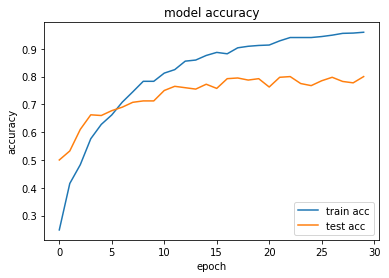

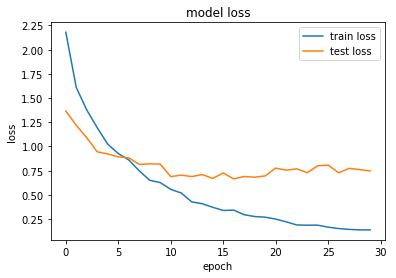

In [12]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train acc', 'test acc'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'test loss'], loc='upper right')
plt.show()

#### Evaluation of the trained network


In [13]:
preds_test=model.predict(X_test)

In [14]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test[:],np.argmax(preds_test,axis=1)))
print("Acc = " ,np.sum(Y_test[:]==np.argmax(preds_test,axis=1))/len(preds_test))

[[40  1  1  1  0  1  5  1]
 [ 0 43  0  2  2  2  0  1]
 [ 1  0 46  0  0  0  1  2]
 [ 0  5  0 42  0  1  2  0]
 [ 0  6  0  2 39  1  2  0]
 [ 0  1  0  1  0 45  3  0]
 [ 3  1  1  4  0  4 37  0]
 [ 0  5  3  0  1  1  1 39]]
Acc =  0.8275


In [15]:
# Downloading the data, if it does not exist
if not os.path.isfile('8_faces_test.hdf5'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/ugxrdo0lpc2ixvr/8_faces_test.hdf5?dl=1",
    "8_faces_test.hdf5")

In [16]:
h5f_X = h5py.File('8_faces_test.hdf5', 'r')
print(list(h5f_X.keys()))
X_test = h5f_X['X_test_8_faces']
print(X_test.shape)
Y_test = h5f_X['Y_test_8_faces']
print(Y_test.shape)


['X_test_8_faces', 'Y_test_8_faces']
(400, 48, 48, 3)
(400,)


#### Visualize right and wrong classified images

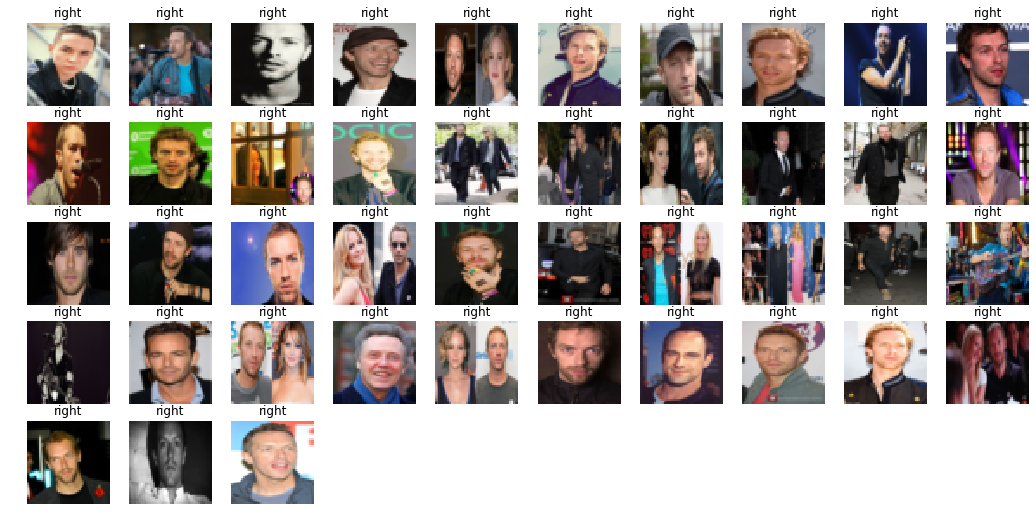

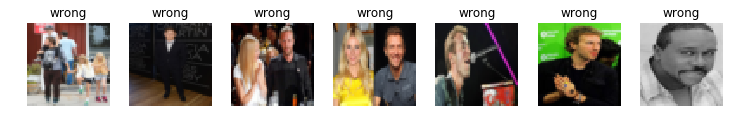

In [17]:
pred=np.argmax(preds_test,axis=1)
Klasse=1
right = np.where(Y_test[:]==Klasse)[0][np.where(np.in1d(np.where(Y_test[:]==Klasse),np.where(pred[:]==Klasse)))]
wrong = np.where(Y_test[:]==Klasse)[0][(np.in1d(np.where(Y_test[:]==Klasse),np.where(pred[:]==Klasse)))==False]

plt.figure(figsize=(18,18))
for i in range(0,len(right)):
    plt.subplot(10,10,(i+1))
    plt.imshow(np.asarray(X_test[right[i]],dtype="uint8"))
    plt.axis('off')
    plt.title('right')
    
plt.figure(figsize=(18,18))
for i in range(0,len(wrong)):
    plt.subplot(10,10,(i+1))
    plt.imshow(np.asarray(X_test[wrong[i]],dtype="uint8"))
    plt.axis('off')
    plt.title('wrong')